In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../../data/preprocessed_data/시도_시군구별_보행자_사고_사고유형_전처리ver.csv')

# 피해 가중 점수 계산
df['피해가중점수'] = (
    df['사망자수'] * 1 +
    df['중상자수'] * 0.1 +
    df['경상자수'] * 0.01 +
    df['부상신고자수'] * 0.001
)

# 가중치 계산
avg_by_area = df.groupby('시군구')['피해가중점수'].mean().to_dict()
type_weight = df.groupby('사고유형')['피해가중점수'].mean()
road_weight = df.groupby('도로형태')['피해가중점수'].mean()

# 파생 변수 생성
df['사고도로조합'] = df['사고유형'] + '_' + df['도로형태']
df['시군구_평균사고'] = df['시군구'].map(avg_by_area)
df['사고유형가중치'] = df['사고유형'].map(type_weight)
df['도로형태가중치'] = df['도로형태'].map(road_weight)
df['최종위험점수'] = df['피해가중점수'] + 0.5 * (df['사고유형가중치'] + df['도로형태가중치'])

# 타겟 설정: 위험 시군구 여부 (상위 20% 위험도 기준)
avg_risk_by_area = df.groupby('시군구')['최종위험점수'].mean()
threshold = avg_risk_by_area.quantile(0.8)
df['시군구_위험여부'] = df['시군구'].map(lambda x: int(avg_risk_by_area[x] > threshold))
HTML(df.head(5).to_html(index=False))

# 데이터 저장
# df.to_csv('../../data/preprocessed_data/시도_시군구별_보행자_사고_사고유형_전처리ver_최종위험점수.csv', index=False)

연도,시군구,법정동코드,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,도로형태,피해자 상해정도,피해가중점수,사고도로조합,시군구_평균사고,사고유형가중치,도로형태가중치,최종위험점수,시군구_위험여부
2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로부근,중상,0.10,차대사람 - 차도통행중_교차로 - 교차로부근,0.10,0.131882,0.111938,0.221910,0
2020,서울특별시 종로구 창성동,1111010500,중상사고,0,1,0,0,차대사람 - 차도통행중,교차로 - 교차로안,중상,0.10,차대사람 - 차도통행중_교차로 - 교차로안,0.10,0.131882,0.117951,0.224917,0
2020,서울특별시 종로구 통인동,1111010800,경상사고,0,0,1,0,차대사람 - 기타,단일로 - 기타,경상,0.01,차대사람 - 기타_단일로 - 기타,0.01,0.092425,0.121204,0.116814,0
2020,서울특별시 종로구 누상동,1111010900,경상사고,0,0,1,0,차대사람 - 차도통행중,교차로 - 교차로안,경상,0.01,차대사람 - 차도통행중_교차로 - 교차로안,0.01,0.131882,0.117951,0.134917,0
2020,서울특별시 종로구 누상동,1111010900,경상사고,0,0,1,0,차대사람 - 기타,단일로 - 기타,경상,0.01,차대사람 - 기타_단일로 - 기타,0.01,0.092425,0.121204,0.116814,0



📍 [분석 리포트: 서울특별시 종로구 누상동]
- 평균 위험 점수: 0.126
- 시군구 위험 여부: 안전
- 자주 발생한 사고유형:
사고유형
차대사람 - 차도통행중    1
차대사람 - 기타       1
- 자주 발생한 도로형태:
도로형태
교차로 - 교차로안    1
단일로 - 기타      1


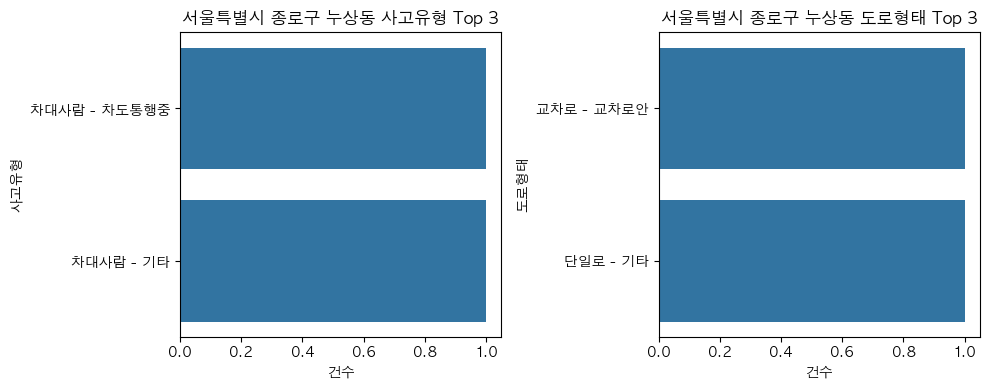

In [3]:
# 키워드 기반 리포트 함수
def analyze_area_by_keyword(keyword: str, df, top_n=3, show_plot=True):
    # 해당 keyword가 포함된 시군구 리스트 추출
    matched_areas = df['시군구'].unique()
    matched_areas = [area for area in matched_areas if keyword in area]

    if not matched_areas:
        print(f"[❌] '{keyword}'를 포함하는 시군구가 없습니다.")
        return

    for area_name in matched_areas:
        area_df = df[df['시군구'] == area_name]
        avg_risk = avg_risk_by_area.get(area_name, 0)
        top_types = area_df['사고유형'].value_counts().head(top_n)
        top_roads = area_df['도로형태'].value_counts().head(top_n)
        danger_value = df['시군구_위험여부'].iloc[0]                    # df['시군구_위험여부']값이 1이면 '위험' 아니면 '안전'
        danger_or_not = '위험' if danger_value == 1 else '안전'

        print(f"\n📍 [분석 리포트: {area_name}]")
        print(f"- 평균 위험 점수: {avg_risk:.3f}")
        print(f"- 시군구 위험 여부: {danger_or_not}")
        print("- 자주 발생한 사고유형:")
        print(top_types.to_string())
        print("- 자주 발생한 도로형태:")
        print(top_roads.to_string())

        if show_plot:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            sns.countplot(data=area_df, y='사고유형', order=top_types.index)
            plt.title(f"{area_name} 사고유형 Top {top_n}")
            plt.xlabel("건수")

            plt.subplot(1, 2, 2)
            sns.countplot(data=area_df, y='도로형태', order=top_roads.index)
            plt.title(f"{area_name} 도로형태 Top {top_n}")
            plt.xlabel("건수")

            plt.tight_layout()
            plt.show()

analyze_area_by_keyword("누상동", df)